# Binary Classification Project
### Author: Edi Ferdman

##### 2 datasets provided: training and testing.
##### Task: Binary Classfication

In [1]:
import pandas as pd
import numpy as np
import os
import time

import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold

import warnings
warnings.filterwarnings("ignore")

In [2]:
os.chdir('C:\\Users\\Eddie\\Documents\\StateFarm')

In [3]:
training = pd.read_csv('exercise_05_train.csv')
test = pd.read_csv('exercise_05_test.csv')

In [4]:
print('training set: ', training.shape)
print('testing set: ', test.shape)

training set:  (40000, 101)
testing set:  (10000, 100)


In [4]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 101 entries, x0 to y
dtypes: float64(94), int64(1), object(6)
memory usage: 30.8+ MB


In [5]:
training.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,0.963686,6.627185,-45.224008,9.477531,-3.216532,13.216874,9.754747,5.245851,-1.102918,-2.867482,...,0.988829,0.313772,asia,1.380664,-16.388994,5.326730,4.187294,0.045549,-3.646841,0
1,-1.770062,-23.610459,-0.964003,-31.981497,-10.294599,-10.240251,-1.518888,-1.675208,0.498134,-0.614390,...,-2.162863,1.809807,asia,2.500590,4.338834,-1.583225,-1.172417,0.011216,0.097180,0
2,9.962401,-8.349849,23.248891,-24.196879,8.937480,10.965000,-7.490596,-3.025094,0.595807,0.382732,...,1.779660,9.528113,asia,1.396475,7.839188,10.402396,1.288991,0.008209,-4.132316,0
3,-5.780709,-25.261584,1.383115,-11.786929,7.993078,-11.245752,-2.607351,-3.513896,-0.614235,-1.453979,...,-0.203206,4.892248,asia,0.744317,7.380982,7.599323,-8.022884,-0.067624,-1.796198,0
4,1.211541,1.119963,7.512938,21.987312,-5.155392,10.339416,3.045180,-0.619230,-0.928068,0.405024,...,0.248724,18.694990,asia,1.703196,-11.552129,0.381768,-3.550471,-0.055180,-3.344490,0


#### Null values summary

In [6]:
#Training Set
null_df_training = pd.DataFrame({'NullCount': training.isnull().sum(), 'NullPerc': training.isnull().sum() / len(training) * 100})
null_df_training.sort_values(by = 'NullPerc', ascending = False, inplace = True)
null_df_training.reset_index(inplace = True)
null_df_training

,index,NullCount,NullPerc
0,x55,16,0.0400
1,x13,15,0.0375
2,x18,14,0.0350
3,x96,14,0.0350
4,x73,13,0.0325
...,...,...,...
96,x29,3,0.0075
97,x91,2,0.0050
98,x30,2,0.0050
99,x43,1,0.0025


##### Investigate Categorical Variables:

In [7]:
print('training:', training.select_dtypes(['object']).columns)

training: Index(['x34', 'x35', 'x41', 'x45', 'x68', 'x93'], dtype='object')


In [8]:
for var in training.select_dtypes(['object']).columns:
    print(training[var].head(), '\n')

0     chrystler
1    volkswagon
2           bmw
3        nissan
4    volkswagon
Name: x34, dtype: object 

0       thur
1       thur
2    thurday
3    thurday
4        wed
Name: x35, dtype: object 

0    $-865.28
1     $325.27
2     $743.91
3     $538.48
4    $-433.65
Name: x41, dtype: object 

0     0.02%
1    -0.01%
2      0.0%
3     0.01%
4      0.0%
Name: x45, dtype: object 

0    sept.
1     July
2     July
3     July
4      Jun
Name: x68, dtype: object 

0    asia
1    asia
2    asia
3    asia
4    asia
Name: x93, dtype: object 



In [9]:
for var in training.select_dtypes(['object']).columns:
    print(var)
    print(training[var].unique(), '\n')

x34
['chrystler' 'volkswagon' 'bmw' 'nissan' 'tesla' 'Toyota' 'Honda'
 'mercades' 'ford' 'chevrolet' nan] 

x35
['thur' 'thurday' 'wed' 'tuesday' 'wednesday' 'friday' 'fri' 'monday' nan] 

x41
['$-865.28' '$325.27' '$743.91' ... '$60.77' '$-982.23' '$-904.25'] 

x45
['0.02%' '-0.01%' '0.0%' '0.01%' '-0.0%' '-0.02%' '-0.03%' '0.03%' nan
 '0.04%' '-0.04%'] 

x68
['sept.' 'July' 'Jun' 'Nov' 'Mar' 'May' 'Oct' 'Aug' 'Apr' 'Dev' 'Feb'
 'January' nan] 

x93
['asia' 'america' 'euorpe' nan] 



### Data Wrangling/Clean Up

In [10]:
def change_dollar_to_float(value):
    value = str(value)
    if value[0] == '$':
        value = value[1:]
    
    value = value.replace(',', '')
    return float(value)

def change_percent_to_float(value):
    value = str(value)
    if value[-1] == '%':
        value = value[:-1]
    
    return float(value)

In [11]:
def dataset_cleanup(dataset):
    #var x34: Fix spelling and capitalize first letter for consistency
    dataset['x34'] = dataset['x34'].replace({'mercades': 'Mercedes'})
    dataset['x34'] = dataset['x34'].apply(lambda x: x if x is np.nan else x.capitalize())
    
    #var x35: change format to one consistent format
    dataset['x35'] = dataset['x35'].replace({'wed': 'wednesday', 
                                               'thur': 'thursday', 
                                               'thurday': 'thursday', 
                                               'fri': 'friday'})

    #var x41: change $ amount to float:
    dataset['x41'] = dataset['x41'].apply(lambda x: change_dollar_to_float(x))

    #var 45: change % to float
    dataset['x45'] = dataset['x45'].apply(lambda x: change_percent_to_float(x))

    #var x68: change to consistent format
    dataset['x68'] = dataset['x68'].replace({'sept.': 'Sep',
                                               'July': 'Jul',
                                               'Dev': 'Dec',
                                               'January': 'Jan'})

    #var x93: replace euorpe with europe
    dataset['x93'] = dataset['x93'].replace({'euorpe': 'europe'})

In [12]:
dataset_cleanup(training)

In [13]:
#Same code as before cleanup function to see if everything is fixed

for var in training.select_dtypes(['object']).columns:
    print(var)
    print(training[var].unique(), '\n')

x34
['Chrystler' 'Volkswagon' 'Bmw' 'Nissan' 'Tesla' 'Toyota' 'Honda'
 'Mercedes' 'Ford' 'Chevrolet' nan] 

x35
['thursday' 'wednesday' 'tuesday' 'friday' 'monday' nan] 

x68
['Sep' 'Jul' 'Jun' 'Nov' 'Mar' 'May' 'Oct' 'Aug' 'Apr' 'Dec' 'Feb' 'Jan'
 nan] 

x93
['asia' 'america' 'europe' nan] 



### Fill in missing values

In [14]:
categorical_features = training.select_dtypes(['object']).columns

In [15]:
#Fill in missing values with mean for numberical features and mode for categorical features.
for var in training.columns:
    if var in categorical_features:
        training[var] = training[var].fillna(training[var].mode()[0])
    else:
        training[var] = training[var].fillna(training[var].mean())

In [16]:
#Test for null values again
training.isnull().sum().sum()

0

Now all the categorical variables are clean and there are no null values

### EDA

In [17]:
#target class count
print('Target variable frequency: \n')
print('1: ', training['y'].sum())
print('0: ', len(training) - training['y'].sum())
print("%% of 1's: %.3f%%" % (training['y'].sum() / (len(training)) * 100))

Target variable frequency: 

1:  8147
0:  31853
% of 1's: 20.367%


In [18]:
#A quick view at the class counts for categorical values
for var in training.select_dtypes(['object']).columns:
    display(pd.crosstab(training[var], training['y']))

y,0,1
x34,,
Bmw,5782,1480
Chevrolet,10,1
Chrystler,963,228
Ford,128,32
Honda,4135,1039
Mercedes,27,4
Nissan,261,65
Tesla,1785,462
Toyota,8719,2249


y,0,1
x35,,
friday,445,98
monday,31,22
thursday,14716,3036
tuesday,582,302
wednesday,16079,4689


y,0,1
x68,,
Apr,1217,412
Aug,6585,1585
Dec,10,6
Feb,26,22
Jan,9,3
Jul,9013,2110
Jun,7481,1836
Mar,303,104
May,3719,1025


y,0,1
x93,,
america,2490,677
asia,28206,7185
europe,1157,285


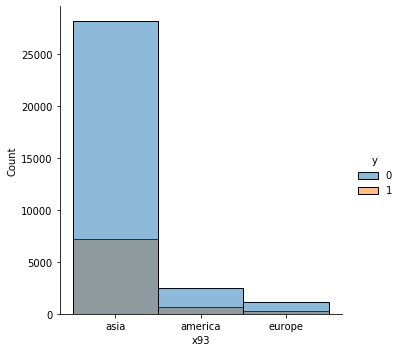

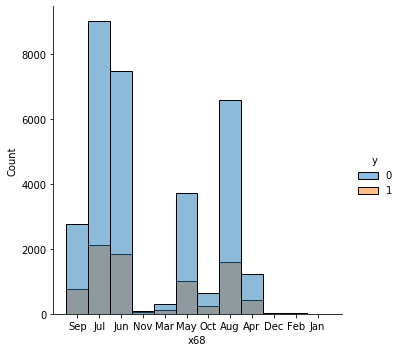

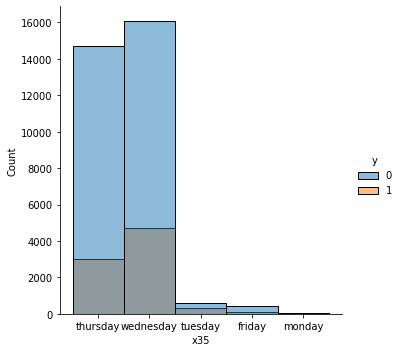

In [19]:
#Below is a visualiztion of the crosstab data from above.
for var in ['x93', 'x68', 'x35']:
    sns.displot(training, x = var, hue = 'y')
plt.show()

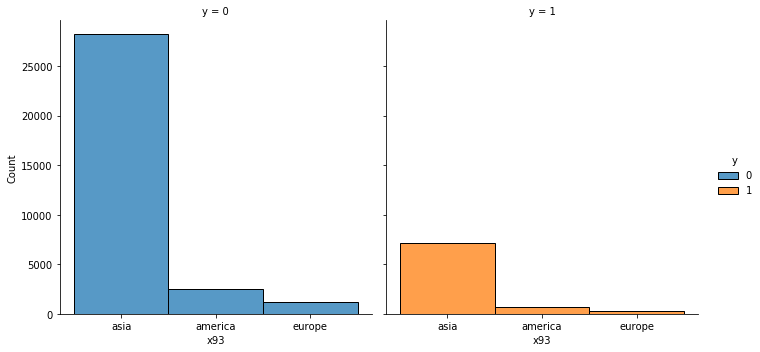

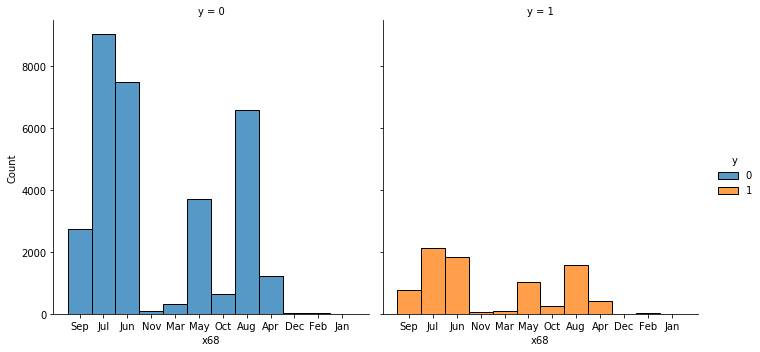

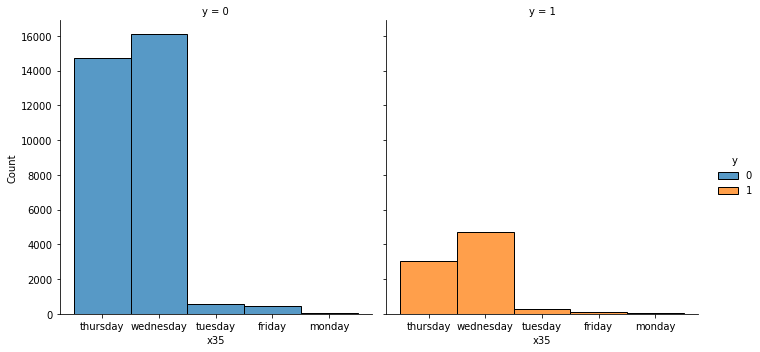

In [20]:
#Below is a visualiztion of the crosstab data from above.
for var in ['x93', 'x68', 'x35']:
    sns.displot(training, x = var, col = 'y', hue = 'y')
plt.show()


From the above visualizations, we can see that the distribution is the same for both classes for each categorical variable

#### Univariate Analysis

In [21]:
numerical_features = training.select_dtypes(['number']).columns

In [22]:
len(numerical_features) - 1 #without counting y variable

96

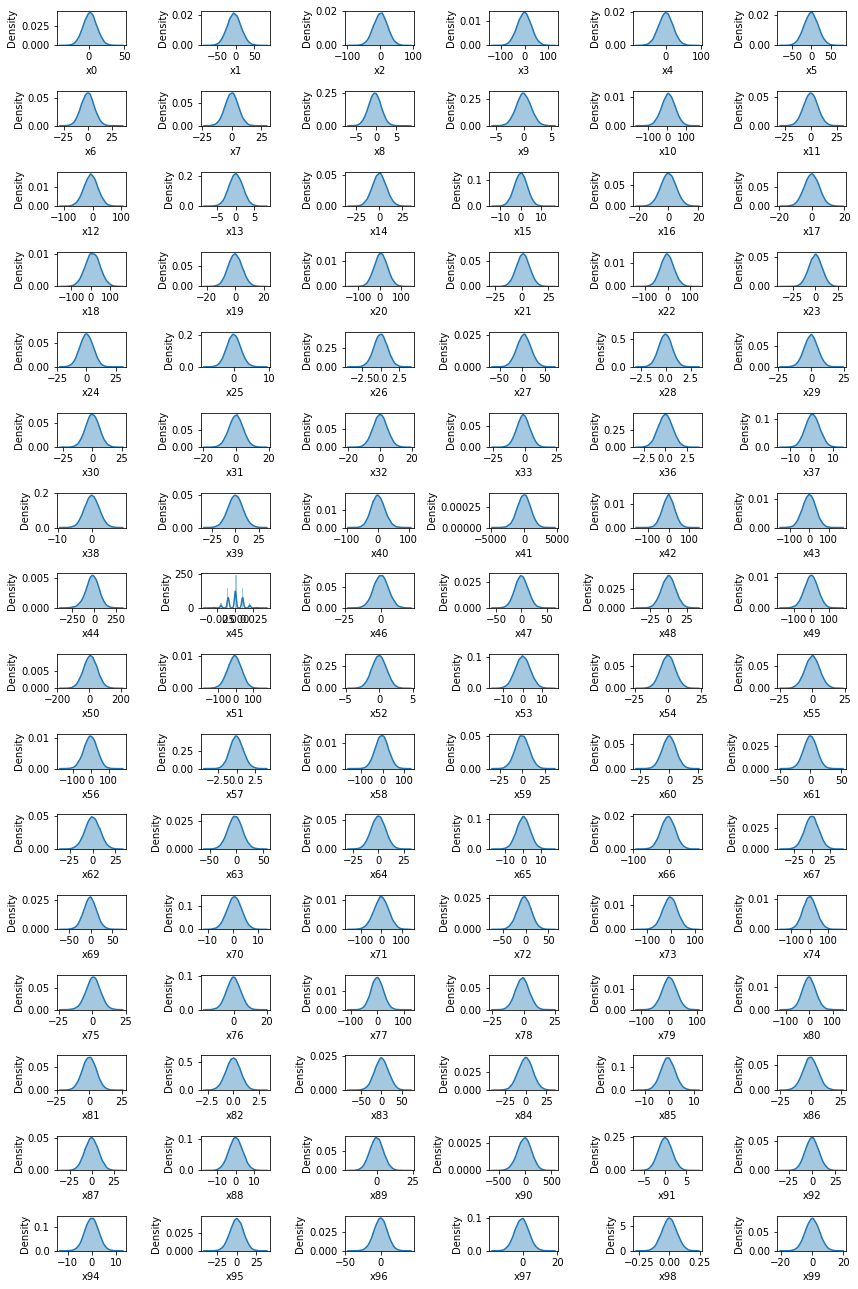

In [23]:
fig = plt.figure(figsize = (12, 18))

for i in range(len(numerical_features) - 1): #removing 1 for the y variable in the end
    fig.add_subplot(16,6,i+1)
    sns.distplot(training[numerical_features[i]])

    
plt.tight_layout()
plt.show()

All the variables appear to be from a normal distribution which is very desirable for many machine learning algorithms.

In [ ]:
# We can calculate the skewness and kurtosis of each variable for a numerical representation of their distribution,
# but the results are not very interesting. All the variables are approximately normal.
for var in training.select_dtypes('number').columns:
    print(var)
    print('skew: ', training[var].skew())
    print('kurtosis: ', training[var].kurt())
    print('\n')

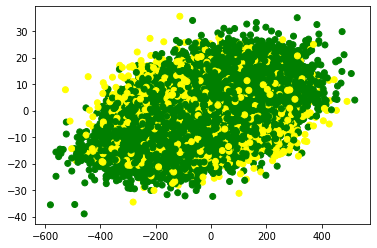

In [22]:
#histogram with color class
colors = {1: 'yellow', 0: 'green'}

fix, ax = plt.subplots()

ax.scatter(training['x90'], training['x95'], c = training['y'].map(colors))

plt.show()


In [ ]:
for i in training.select_dtypes(['number']).columns:
    print(training[i].describe())
    print('\n')

#### Correlation

In [23]:
corr = training.corr()

In [24]:
corr['y'].sort_values(ascending = False)

y      1.000000
x97    0.187624
x58    0.185919
x1     0.104977
x99    0.099601
         ...   
x22   -0.097637
x70   -0.106798
x41   -0.177508
x37   -0.197748
x75   -0.204687
Name: y, Length: 97, dtype: float64

In [25]:
def heatmap(x, y, size, color):
    fix, ax = plt.subplots(figsize = (25,25))
    
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)}
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)}
    
    size_scale = 500
    
    palette = sns.diverging_palette(20,220,n=256)
    color_min, color_max = [-1,1]
    
    def value_to_color(val):
        val_position = float((val - color_min)) / (color_max - color_min)
        ind = int(val_position * (255))
        return palette[ind]
    
    ax.scatter(
        x=x.map(x_to_num),
        y=y.map(y_to_num),
        s=size*size_scale,
        c=color.apply(value_to_color),
        marker='s'
    )
    
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)
    
    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor = True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor = True)
    
    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    
    

In [26]:
corr = pd.melt(corr.reset_index(), id_vars = 'index')

In [27]:
corr.head()

,index,variable,value
0,x0,x0,1.000000
1,x1,x0,-0.216073
2,x2,x0,-0.159510
3,x3,x0,-0.144056
4,x4,x0,-0.258273


Below is a special form of a correlation heatmap matrix. With this many variables the standard correlation matrix is difficult to look at. With the below matrix, correlation values closer to 0 are represented with small squares and washed out color. The correlations closer to 1 or -1 have larger squares with vivid color which draw the user's attention.

From the below matrix, we see that none of the variables are too correlated.

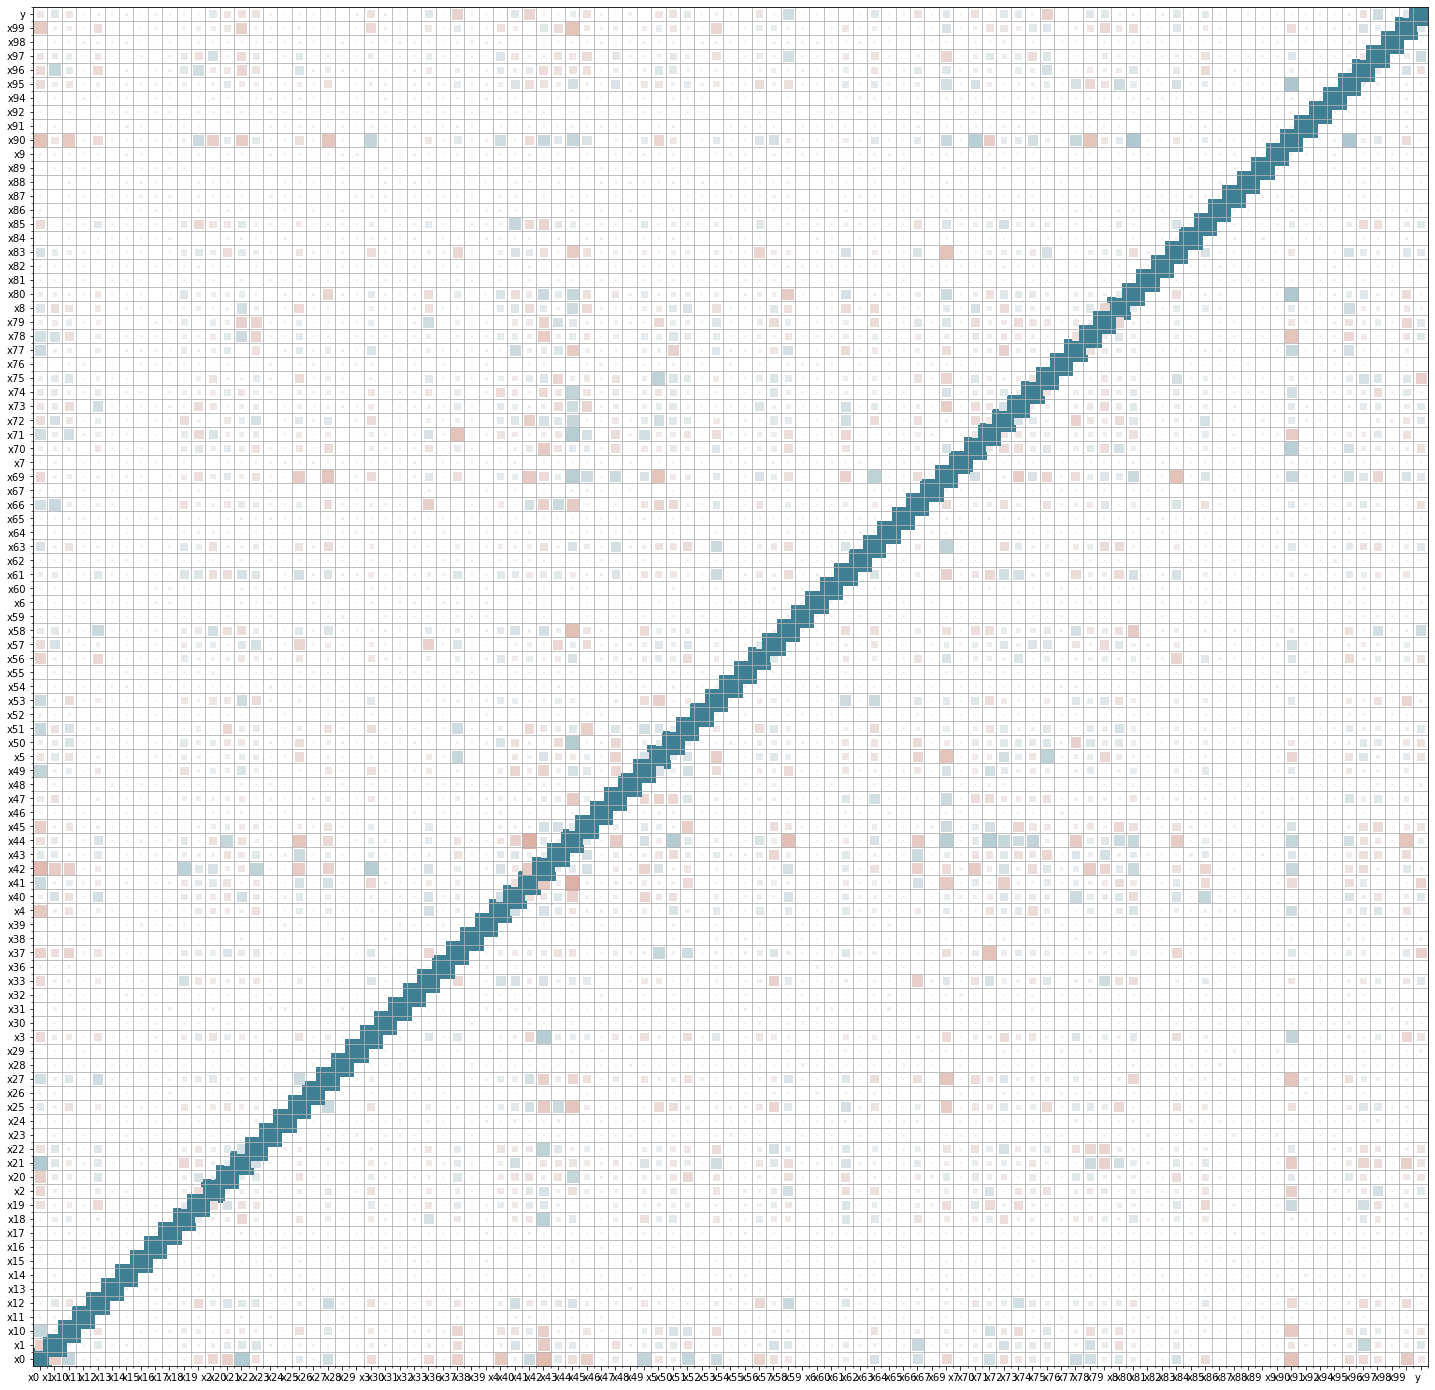

In [28]:
heatmap(
    x = corr['index'],
    y = corr['variable'],
    size = corr['value'].abs(),
    color = corr['value']
    )

In [36]:
corr2 = corr[corr['value'] != 1]
display(corr2[corr2['value'] == corr2['value'].max()])
display(corr2[corr2['value'] == corr2['value'].min()])

,index,variable,value
8530,x95,x90,0.376848
8914,x90,x95,0.376848


,index,variable,value
3825,x44,x41,-0.411044
4113,x41,x44,-0.411044


## Modeling

In [29]:
def performance(y_test, y_pred):
    #Confusion Matrix:
    CM = confusion_matrix(y_test, y_pred)
    
    #Accuracy score
    Acc_score = accuracy_score(y_test, y_pred)
    
    #Recall Score
    Rec_score = recall_score(y_test, y_pred)
    
    #Precision Score
    Prec_score = precision_score(y_test, y_pred)
    
    print('Confusion Matrix: \n', CM, '\n')
    
    print('Accuracy Score: %.3f \n' % Acc_score)
    print('Precision Score: % .3f \n' % Prec_score)
    print('Recall Score: %.3f' % Rec_score)

##### Remove y variable and get_dummies for categorical features

In [30]:
y = training['y']
training.drop(['y'], axis = 1, inplace = True)

#Get dummies for categorical features
training_dummies = pd.get_dummies(training.select_dtypes('object'), drop_first = True)
training = training.drop(list(training.select_dtypes('object').columns), axis = 1)
training = pd.concat([training, training_dummies], axis = 1)
training.shape

(40000, 122)

##### Separate data into train and test set  and scale data

In [31]:
X_train, X_test, y_train, y_test = train_test_split(training, y, random_state = 42)

In [32]:
#Scale X_train and transform X_train, X_test
scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

##### Base case for model 1: Logistic Regression

In [33]:
clf_LR_base =LogisticRegression()
clf_LR_base #To see the base case hyperparameter values

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
#Fit and make predictions for model1
start_time = time.time()

clf_LR_base.fit(X_train, y_train)
y_pred_LR_base = clf_LR_base.predict(X_test)
y_pred_proba_LR_base = clf_LR_base.predict_proba(X_test)

print('run time: ', time.time() - start_time)

run time:  1.2334728240966797


In [35]:
#Performance:
performance(y_test, y_pred_LR_base)

Confusion Matrix: 
 [[7613  333]
 [ 791 1263]] 

Accuracy Score: 0.888 

Precision Score:  0.791 

Recall Score: 0.615


In [36]:
#AUC score
auc_score = roc_auc_score(y_test, y_pred_proba_LR_base[:,1])
print('LR base AUC score = %.3f' % auc_score)

LR base AUC score = 0.907


##### Base case for model 2: xgboost

In [45]:
from xgboost import XGBClassifier

In [46]:
clf_XGB_base = XGBClassifier()
clf_XGB_base

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, use_label_encoder=True,
              validate_parameters=None, verbosity=None)

In [47]:
start_time = time.time()

clf_XGB_base.fit(X_train, y_train)

print(time.time() - start_time)

[16:16:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
15.912088632583618


In [48]:
y_pred_XGB_base = clf_XGB_base.predict(X_test)

In [49]:
performance(y_test, y_pred_XGB_base)

Confusion Matrix: 
 [[7887   59]
 [ 310 1744]] 

Accuracy Score: 0.963 

Precision Score:  0.967 

Recall Score: 0.849


In [50]:
y_pred_proba_XGB_base = clf_XGB_base.predict_proba(X_test)

In [51]:
#AUC score: XGBClassifier
auc_score = roc_auc_score(y_test, y_pred_proba_XGB_base[:,1])
print('XGB base AUC score = %.3f' % auc_score)

XGB base AUC score = 0.984


### Hyperparamer tuning: Attempt at improving the models

##### LogisticRegression Tuning

In [52]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [53]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalties = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

parameters = dict(logistic_reg__C = c_values,
                  logistic_reg__penalty = penalties,
                  logistic_reg__solver = solvers)

In [54]:
scl = StandardScaler()

In [55]:
logistic_reg = LogisticRegression(max_iter = 500)

In [57]:
pipe = Pipeline(steps = [('scl', scl),
                         ('logistic_reg', logistic_reg)])

In [58]:
clf_LR_GS = GridSearchCV(pipe, parameters, scoring = 'roc_auc', n_jobs = -1)

In [59]:
start_time = time.time()

clf_LR_GS.fit(training, y)

print(time.time() - start_time)

97.2472596168518


In [60]:
print('best solver :', clf_LR_GS.best_estimator_.get_params()['logistic_reg__solver'])
print('best C: ', clf_LR_GS.best_estimator_.get_params()['logistic_reg__C'])

best solver : liblinear
best C:  1.0


Best hyperparameters are the same as original base Logistic Regression model

##### Hyperparameter tuning for xgboost

In [61]:
xgb_clf = XGBClassifier()

In [62]:
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [63]:
learning_rate = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
max_depth = [3, 4, 5, 6, 8, 10, 12, 15]
min_child_weight = [1, 3, 5, 7]
gamma = [0.0, 0.1, 0.2 , 0.3, 0.4]
colsample_bytree = [0.3, 0.4, 0.5 , 0.7]
 

parameters_xgb = dict(xgb_clf__learning_rate = learning_rate,
                      xgb_clf__max_depth = max_depth,
                      xgb_clf__min_child_weight = min_child_weight,
                      xgb_clf__gamma = gamma,
                      xgb_clf__colsample_bytree = colsample_bytree)

In [64]:
pipe_xgb = Pipeline(steps = [('scl', scl),
                         ('xgb_clf', xgb_clf)])

In [65]:
clf_xgb_GS = RandomizedSearchCV(pipe_xgb, parameters_xgb, scoring = 'roc_auc', n_iter = 50)

In [ ]:
clf_xgb_GS.fit(training, y)

# Prepare test set and create prediction for each model

In [66]:
test = pd.read_csv('exercise_05_test.csv')

In [67]:
test.shape

(10000, 100)

need to clean up the data 

need to compare the  categorical features to make sure there are no unknown values compared to training set

need to transform the data

need to create probablities

need to save to file

In [69]:
#Training Set
null_df_test = pd.DataFrame({'NullCount': test.isnull().sum(), 'NullPerc': test.isnull().sum() / len(training) * 100})
null_df_test.sort_values(by = 'NullPerc', ascending = False, inplace = True)
null_df_test.reset_index(inplace = True)
print('number of missing values: ', test.isnull().sum().sum())
null_df_test

number of missing values:  194


,index,NullCount,NullPerc
0,x63,7,0.0175
1,x48,6,0.0150
2,x24,5,0.0125
3,x86,5,0.0125
4,x65,4,0.0100
...,...,...,...
95,x54,0,0.0000
96,x70,0,0.0000
97,x71,0,0.0000
98,x73,0,0.0000


In [70]:
for var in test.select_dtypes(['object']).columns:
    print(var)
    print(test[var].unique(), '\n')

x34
['bmw' 'tesla' 'Honda' 'volkswagon' 'Toyota' 'chrystler' 'nissan' 'ford'
 'mercades' 'chevrolet' nan] 

x35
['thurday' 'thur' 'wed' 'tuesday' 'wednesday' 'friday' 'monday' 'fri' nan] 

x41
['$107.93' '$-600.43' '$103.08' ... '$266.76' '$-1067.69' '$1298.42'] 

x45
['0.0%' '0.02%' '-0.0%' '-0.01%' '0.01%' '0.03%' '-0.02%' '-0.03%' '0.04%'
 '-0.04%'] 

x68
['Jun' 'May' 'sept.' 'Aug' 'July' 'Oct' 'Apr' 'Mar' 'Dev' 'Nov' nan 'Feb'
 'January'] 

x93
['asia' 'america' 'euorpe' nan] 



We can see the data in the test set has the same issues as the training set and does not include any new values not previously seen in the training set. Same clean up procedure will work for the testing set.

In [71]:
#Test set has exactly the same cleanup requirements as the training set. The same clean up function should be okay.
dataset_cleanup(test)

In [72]:
for var in test.select_dtypes(['object']).columns:
    print(var)
    print(test[var].unique(), '\n')

x34
['Bmw' 'Tesla' 'Honda' 'Volkswagon' 'Toyota' 'Chrystler' 'Nissan' 'Ford'
 'Mercedes' 'Chevrolet' nan] 

x35
['thursday' 'wednesday' 'tuesday' 'friday' 'monday' nan] 

x68
['Jun' 'May' 'Sep' 'Aug' 'Jul' 'Oct' 'Apr' 'Mar' 'Dec' 'Nov' nan 'Feb'
 'Jan'] 

x93
['asia' 'america' 'europe' nan] 



In [73]:
#filling in null values
categorical_attributes = test.select_dtypes(['object']).columns

#Fill in missing values with mean for numberical features and mode for categorical features.
for var in test.columns:
    if var in categorical_attributes:
        test[var] = test[var].fillna(test[var].mode()[0])
    else:
        test[var] = test[var].fillna(test[var].mean())

In [74]:
test.isnull().sum().sum()

0

In [75]:
#categorical featrues are the same for test set and training set >> create same dummy features
test_dummies = pd.get_dummies(test.select_dtypes('object'), drop_first = True)
test = test.drop(list(categorical_attributes), axis = 1)
test = pd.concat([test, test_dummies], axis = 1)

In [76]:
#scale the test set using the same standard scaler used to training set
test = scaler.transform(test)

In [80]:
#make prediction and save to file
LR_predictions = clf_LR_base.predict_proba(test)

In [81]:
pd.DataFrame(LR_predictions[:,1]).to_csv('results1.csv', index = False)

In [82]:
#make predictions using svm model
XGB_predictions = clf_XGB_base.predict_proba(test)

In [83]:
pd.DataFrame(XGB_predictions[:,1]).to_csv('results2.csv', index = False)

In [84]:
X_test.shape

(10000, 122)

##### Predictions double check counts

The testing subset of the training set used in during model fitting had the same number of observations as the test set. Below I compare the number of 1's predicted in both sets using both models

In [97]:
print("Logistic Regression: # of 1's predictioned during training out of 10000: ", y_pred_LR_base.sum())
print("Logistic Regression: # of 1's predicted with test set out of 10000: ", clf_LR_base.predict(test).sum())

Logistic Regression: # of 1's predictioned during training out of 10000:  1596
Logistic Regression: # of 1's predicted with test set out of 10000:  1550


In [98]:
print("XGBoost: # of 1's predictioned during training out of 10000: ", y_pred_XGB_base.sum())
print("XGBoost: # of 1's predicted with test set out of 10000: ", clf_XGB_base.predict(test).sum())

XGBoost: # of 1's predictioned during training out of 10000:  1803
XGBoost: # of 1's predicted with test set out of 10000:  1795


The number of 1's predicted by both models is very similar among the test dataset and the X_test set during training